In [1]:
!pip install keras-vggface

Importiamo le librerie necessarie.

In [1]:
from keras_vggface.vggface import VGGFace
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Conv2D, Input, MaxPooling2D, Activation
from keras.preprocessing.image import ImageDataGenerator
import random
from keras.optimizers import SGD
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.constraints import Constraint
from keras.models import load_model
from keras.callbacks import CSVLogger
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd


Using TensorFlow backend.


Carichiamo il modello della **VGGFace** e settiamo la dimensione dell'immagine a 224X224. Il modello caricato è quello della vggface basato però sulla vgg16, come indicato dalla parola **model**.

In [2]:
IMAGE_SIZE = 224
vggface = VGGFace(model='vgg16', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

Consideriamo tutti i layer della VGGFace aggiungendone e modificandone alcuni. E' stato aggiunto un layer **Dropout**, con dropout rate settato a 0.7, dopo il primo layer fully connected del modello. Sono stati eliminati gli ultimi due layer (tramite la funzione pop()) aggiungendo un layer Dense con numero di classi pari a 7.

In [3]:
vggface.layers.pop()
vggface.layers.pop()
layers = [l for l in vggface.layers]
for i in range(0, 18):
     layers[i].trainable = False

x = Dropout(0.7, name = 'Dropout')(layers[21].output)
for i in range(22, len(layers)):
    x = layers[i](x)

x = Dense(7, activation = 'softmax')(x)    
model = Model(inputs = layers[0].input, outputs = x)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

Successivamente carichiamo la cartella contente le immagini di Train e Validation. Attraverso il metodo **ImageDataGenerator** vengono applicate delle funzioni di pre-processing e un flip orizzontale a tali immagini.

In [4]:
train_folder = "../Train"
val_folder = "../Val"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True)

Attraverso il metodo **flow_from_directory** creiamo i batch con le immagini preprocessate. Inizialmente abbiamo settato un batchsize di train pari a 512, successivamente modificato a 32 a causa di un errore dovuto ad un memory leak.

In [5]:
train_batchsize = 32
val_batchsize = 8

train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=train_batchsize,
        class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
        val_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=val_batchsize,
        class_mode="categorical",
        shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


Per evitare di avere una **val_acc** il cui valore rimane invariato per un numero elevato di epoche, utilizziamo il metodo **ReduceLROnPlateau** per decrementare il learning rate di 10 unità ogni 10 epoche. 

In [6]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1 , patience = 10)

csv_logger = CSVLogger('training.log', separator=',', append=False)
callbacks_list = [reduce_lr, csv_logger]

Settiamo un numero di epoche pari a 200 e un learning rate di 10^-4, come ottimizzatore utilizziamo l'**SGD** con un momentum settato a 0.9. E' importante settare questi iperparametri in quanto andranno ad influenzare il training del modello.

In [7]:
num_epochs = 200
learning_rate = 1e-4
sgd = SGD(lr=learning_rate, momentum = 0.9)
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['acc'])

Effettuiamo il training del modello attraverso il metodo **fit_generator** e successivamente salviamo il modello nella cartella saves.

In [8]:
history = model.fit_generator(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    verbose=1,
    callbacks=callbacks_list
)

model.save('../saves/vggFace.hdf5')

Epoch 1/200
898/898 [==============================] - 263s 293ms/step - loss: 1.8004 - acc: 0.4408 - val_loss: 1.4655 - val_acc: 0.5208
Epoch 2/200
898/898 [==============================] - 258s 287ms/step - loss: 1.2704 - acc: 0.5413 - val_loss: 1.1858 - val_acc: 0.5709
Epoch 3/200
898/898 [==============================] - 257s 287ms/step - loss: 1.1299 - acc: 0.5891 - val_loss: 1.3176 - val_acc: 0.5893
Epoch 4/200
898/898 [==============================] - 258s 288ms/step - loss: 1.0439 - acc: 0.6177 - val_loss: 0.9949 - val_acc: 0.5899
Epoch 5/200
898/898 [==============================] - 258s 288ms/step - loss: 0.9677 - acc: 0.6439 - val_loss: 0.9699 - val_acc: 0.6116
Epoch 6/200
898/898 [==============================] - 258s 288ms/step - loss: 0.9081 - acc: 0.6702 - val_loss: 1.3067 - val_acc: 0.6155
Epoch 7/200
898/898 [==============================] - 258s 287ms/step - loss: 0.8522 - acc: 0.6855 - val_loss: 0.9602 - val_acc: 0.6350
Epoch 8/200
898/898 [====================

898/898 [==============================] - 257s 287ms/step - loss: 0.3947 - acc: 0.8618 - val_loss: 1.0617 - val_acc: 0.6721
Epoch 120/200
898/898 [==============================] - 257s 287ms/step - loss: 0.3956 - acc: 0.8644 - val_loss: 1.0580 - val_acc: 0.6679
Epoch 121/200
898/898 [==============================] - 257s 287ms/step - loss: 0.3975 - acc: 0.8609 - val_loss: 1.4318 - val_acc: 0.6673
Epoch 122/200
898/898 [==============================] - 257s 287ms/step - loss: 0.3912 - acc: 0.8644 - val_loss: 1.0617 - val_acc: 0.6676
Epoch 123/200
898/898 [==============================] - 257s 287ms/step - loss: 0.3906 - acc: 0.8649 - val_loss: 1.4434 - val_acc: 0.6640
Epoch 124/200
898/898 [==============================] - 258s 287ms/step - loss: 0.3973 - acc: 0.8616 - val_loss: 1.0618 - val_acc: 0.6709
Epoch 125/200
898/898 [==============================] - 257s 287ms/step - loss: 0.3987 - acc: 0.8608 - val_loss: 1.0513 - val_acc: 0.6723
Epoch 126/200
898/898 [==================

898/898 [==============================] - 258s 287ms/step - loss: 0.3902 - acc: 0.8669 - val_loss: 1.0691 - val_acc: 0.6670
Epoch 179/200
898/898 [==============================] - 258s 287ms/step - loss: 0.3998 - acc: 0.8598 - val_loss: 1.4435 - val_acc: 0.6690
Epoch 180/200
898/898 [==============================] - 257s 287ms/step - loss: 0.3926 - acc: 0.8639 - val_loss: 1.0691 - val_acc: 0.6693
Epoch 181/200
898/898 [==============================] - 258s 287ms/step - loss: 0.3958 - acc: 0.8619 - val_loss: 1.0691 - val_acc: 0.6643
Epoch 182/200
898/898 [==============================] - 258s 287ms/step - loss: 0.3950 - acc: 0.8628 - val_loss: 1.0580 - val_acc: 0.6701
Epoch 183/200
898/898 [==============================] - 257s 287ms/step - loss: 0.3988 - acc: 0.8621 - val_loss: 1.0587 - val_acc: 0.6656
Epoch 184/200
898/898 [==============================] - 258s 287ms/step - loss: 0.3967 - acc: 0.8600 - val_loss: 1.0580 - val_acc: 0.6665
Epoch 185/200
898/898 [==================

Effettuiamo il **plot** delle metriche del modello.

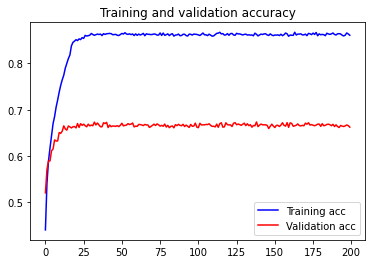

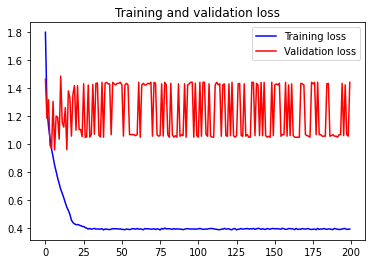

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# TEST

Importiamo le librerie necessarie

In [2]:
import random
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns


Nella funzione creata di seguito si procede con la costruzione della matrice di confusione. 

In [13]:
def show_confusion_matrix(validations, predictions, labels):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Una volta aver creato la matrice di confusione, procediamo con il caricamento delle immagini di test. Esse avranno dimensione 224X224, inoltre la dimensione di batchsize è stata impostata a 1.

In [14]:
test_folder = "../Test"
IMAGE_SIZE = 224
random.seed(3)
test_batchsize = 1

Carichiamo il modello addestrato.

In [15]:
model = load_model('../saves/vggface.hdf5')


Successivamente carichiamo la cartella contente le immagini di Train e Validation. Attraverso il metodo **ImageDataGenerator** vengono applicate delle funzioni di pre-processing e un flip orizzontale a tali immagini. Attraverso il metodo **flow_from_directory** creiamo i batch con le immagini preprocessate.

In [16]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 3589 images belonging to 7 classes.


Andiamo a leggere le classi assegnate agli esempi di test e il corrispettivo indice numerico.

In [17]:
ground_truth = test_generator.classes
label2index = test_generator.class_indices
idx2label = dict((v, k) for k, v in label2index.items())

Attraverso il mettodo **predict_generator** effettuiamo la classificazione delle immagini. 

In [18]:
predictions = model.predict_generator(test_generator,
                      steps=test_generator.samples / test_generator.batch_size,
                      verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

3589/3589 [==============================] - 63s 18ms/step


Una volta completata la classificazione calcoliamo gli errori effettuati dal modello, la matrice di confusione e le metriche prestazionali.

No of errors = 1168/3589


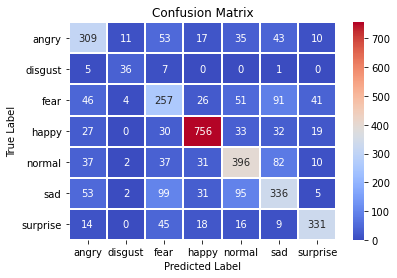

              precision    recall  f1-score   support

           0       0.63      0.65      0.64       478
           1       0.65      0.73      0.69        49
           2       0.49      0.50      0.49       516
           3       0.86      0.84      0.85       897
           4       0.63      0.67      0.65       595
           5       0.57      0.54      0.55       621
           6       0.80      0.76      0.78       433

    accuracy                           0.67      3589
   macro avg       0.66      0.67      0.67      3589
weighted avg       0.68      0.67      0.68      3589



In [19]:
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), test_generator.samples))
labels = ["angry", "disgust", "fear", "happy", "normal", "sad", "surprise"]
show_confusion_matrix(predicted_classes, ground_truth, labels)
print(classification_report(predicted_classes, ground_truth))

# Fase Sparse

Importiamo le librerie necessarie

In [3]:
from keras.layers import Input
from keras.models import Sequential

Carichiamo il modello addestrato

In [4]:
model = load_model('../saves/vggface.hdf5')

Andiamo a definire la clsse **Sparse** con i metodi **_init_**, **_call_** e **get_config**.

In [5]:
class Sparse(Constraint):
    def __init__(self, mask):
        self.mask = K.cast_to_floatx(mask)
    
    def __call__(self,x):
        return self.mask * x
    
    def get_config(self):
        return {'mask': self.mask}

Nella funzione creata di seguito andiamo a calcolare, per ogni layer del modello, una percentuale del peso e se quest'ultima dovesse essere vicina a 0, viene settato a 0 il valore di quel peso. Così facendo restituiamo una maschera con la percentuale dei pesi il più possibile vicina a 0, in modo tale, da incrementare l'accuratezza del modello durante la fase di training. Questo è stato possibile grazie ad una sparsity_mask, nella quale è stato impostato uno sparsity_rate del 60%. 

In [6]:
def create_sparsity_masks(model,sparsity):
    weights_list = model.get_weights()
    masks = []
    for weights in weights_list:
        #We can ignore biases
        if len(weights.shape) > 1:
            weights_abs = np.abs(weights)
            masks.append((weights_abs>np.percentile(weights_abs,sparsity))*1.)
    return masks

Richiamiamo la funzione **create_sparsity_masks** per ottenera una maschera con pesi vicini a 0.

In [7]:
masks = create_sparsity_masks(model,60)

Consideriamo tutti i layer della VGGFace andando a impostare un **kernel_constraint** solo per i layer convoluzionali.

In [8]:
input_ = Input(shape=(224, 224, 3))

x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1', kernel_constraint=Sparse(masks[0]))(input_)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2', kernel_constraint=Sparse(masks[1]))(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1', kernel_constraint=Sparse(masks[2]))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2', kernel_constraint=Sparse(masks[3]))(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1', kernel_constraint=Sparse(masks[4]))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2', kernel_constraint=Sparse(masks[5]))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3', kernel_constraint=Sparse(masks[6]))(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1', kernel_constraint=Sparse(masks[7]))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2', kernel_constraint=Sparse(masks[8]))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3', kernel_constraint=Sparse(masks[9]))(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1', kernel_constraint=Sparse(masks[10]))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2', kernel_constraint=Sparse(masks[11]))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3', kernel_constraint=Sparse(masks[12]))(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool5')(x)

x = Flatten(name='flatten')(x)
x = Dense(4096, name='fc6', kernel_constraint=Sparse(masks[13]))(x)
x = Activation('relu', name='fc6/relu')(x)
x = Dropout(0.7, name = 'Dropout')(x)
x = Dense(4096, name='fc7', kernel_constraint=Sparse(masks[14]))(x)
x = Activation('relu', name='fc7/relu')(x)
x = Dense(7, activation = 'softmax', kernel_constraint=Sparse(masks[15]))(x)

sparse_model = Model(input_, x)
layers = [l for l in sparse_model.layers]
for i in range(0, 18):
     layers[i].trainable = False
        
sparse_model.summary()
#Get weights from densely trained model
sparse_model.set_weights(model.get_weights())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

Successivamente carichiamo la cartella contente le immagini di Train e Validation. Attraverso il metodo **ImageDataGenerator** vengono applicate delle funzioni di pre-processing e un flip orizzontale a tali immagini.

In [9]:
train_folder = "../Train"
val_folder = "../Val"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True)

Attraverso il metodo **flow_from_directory** creiamo i batch con le immagini preprocessate. Inizialmente abbiamo settato un batchsize di train pari a 512, successivamente modificato a 32 a causa di un errore dovuto ad un memory leak.

In [10]:
train_batchsize = 32
val_batchsize = 8
IMAGE_SIZE = 224
train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=train_batchsize,
        class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
        val_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=val_batchsize,
        class_mode="categorical",
        shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


Per evitare di avere una **val_acc** il cui valore rimane invariato per un numero elevato di epoche, utilizziamo il metodo **ReduceLROnPlateau** per decrementare il learning rate di 10 unità ogni 10 epoche. Ci avvaliamo della funzione **CSVLogger** per salvare un file .log contente tutte le informazioni dell'addestramento.

In [11]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1 , patience = 10)

csv_logger = CSVLogger('sparse_training.log', separator=',', append=False)
callbacks_list = [reduce_lr, csv_logger]

Andiamo a leggere i valori dei learning rate dal file **.log** utilizzando il metodo **read_csv** e li inseriamo nella variabile **lr**.

In [10]:
log = pd.read_csv('../notebook/training.log')
dim = len(log['lr'])
lr = log['lr']

Settiamo un numero di epoche pari a 50 e un learning rate uguale all'ultimo valore letto dal file .log, come ottimizzatore utilizziamo l'**SGD** con un momentum settato a 0.9. E' importante settare questi iperparametri in quanto andranno ad influenzare il training del modello.

In [9]:
num_epochs = 50
learning_rate = lr[dim-1]
sgd = SGD(lr=learning_rate, momentum = 0.9)
sparse_model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['acc'])

NameError: name 'sparse_model' is not defined

Effettuiamo il training del modello attraverso il metodo **fit_generator** e successivamente salviamo il modello nella cartella saves.

In [14]:
history = sparse_model.fit_generator(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    verbose=1,
    callbacks=callbacks_list
)
model.save('../saves/sparse_model.hdf5')

Epoch 1/50
898/898 [==============================] - 294s 327ms/step - loss: 0.5269 - acc: 0.8165 - val_loss: 1.1535 - val_acc: 0.6567
Epoch 2/50
898/898 [==============================] - 265s 296ms/step - loss: 0.5260 - acc: 0.8155 - val_loss: 1.1687 - val_acc: 0.6459
Epoch 3/50
898/898 [==============================] - 265s 296ms/step - loss: 0.5249 - acc: 0.8167 - val_loss: 0.9069 - val_acc: 0.6503
Epoch 4/50
898/898 [==============================] - 265s 296ms/step - loss: 0.5311 - acc: 0.8115 - val_loss: 0.9105 - val_acc: 0.6514
Epoch 5/50
898/898 [==============================] - 266s 296ms/step - loss: 0.5199 - acc: 0.8181 - val_loss: 0.9072 - val_acc: 0.6514
Epoch 6/50
898/898 [==============================] - 266s 296ms/step - loss: 0.5211 - acc: 0.8170 - val_loss: 0.9107 - val_acc: 0.6486
Epoch 7/50
898/898 [==============================] - 265s 295ms/step - loss: 0.5251 - acc: 0.8156 - val_loss: 0.9072 - val_acc: 0.6542
Epoch 8/50
898/898 [============================

# Plot fase SPARSE

Effettuiamo il **plot** delle metriche del modello.

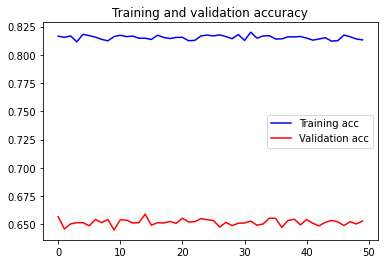

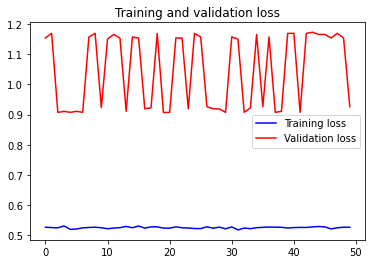

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Test fase SPARSE

Importiamo le librerie necessarie.

In [4]:
import random
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns

Nella funzione creata di seguito si procede con la costruzione della matrice di confusione.

In [3]:
def show_confusion_matrix(validations, predictions, labels):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Una volta aver creato la matrice di confusione, procediamo con il caricamento delle immagini di test. Esse avranno dimensione 224X224, inoltre la dimensione di batchsize è stata impostata a 1.

In [4]:
test_folder = "../Test"
IMAGE_SIZE = 224
random.seed(3)
test_batchsize = 1

Carichiamo il modello addestrato.

In [5]:
model = load_model('../saves/sparse_model.hdf5')

Successivamente carichiamo la cartella contente le immagini di Train e Validation. Attraverso il metodo **ImageDataGenerator** vengono applicate delle funzioni di pre-processing e un flip orizzontale a tali immagini. Attraverso il metodo **flow_from_directory** creiamo i batch con le immagini preprocessate.

In [6]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 3589 images belonging to 7 classes.


Andiamo a leggere le classi assegnate agli esempi di test e il corrispettivo indice numerico.

In [7]:
ground_truth = test_generator.classes
label2index = test_generator.class_indices
idx2label = dict((v, k) for k, v in label2index.items())

Attraverso il mettodo **predict_generator** effettuiamo la classificazione delle immagini. 

In [8]:
predictions = model.predict_generator(test_generator,
                      steps=test_generator.samples / test_generator.batch_size,
                      verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

3589/3589 [==============================] - 66s 18ms/step


Una volta completata la classificazione calcoliamo gli errori effettuati dal modello, la matrice di confusione e le metriche prestazionali.

No of errors = 1168/3589


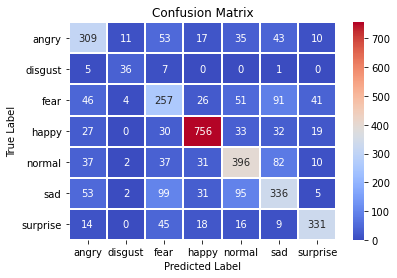

              precision    recall  f1-score   support

           0       0.63      0.65      0.64       478
           1       0.65      0.73      0.69        49
           2       0.49      0.50      0.49       516
           3       0.86      0.84      0.85       897
           4       0.63      0.67      0.65       595
           5       0.57      0.54      0.55       621
           6       0.80      0.76      0.78       433

    accuracy                           0.67      3589
   macro avg       0.66      0.67      0.67      3589
weighted avg       0.68      0.67      0.68      3589



In [9]:
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), test_generator.samples))
labels = ["angry", "disgust", "fear", "happy", "normal", "sad", "surprise"]
show_confusion_matrix(predicted_classes, ground_truth, labels)
print(classification_report(predicted_classes, ground_truth))

# Fase Dense

Importiamo le librerie necessarie.

In [25]:
from keras.layers import Input
from keras.models import Sequential

Carichiamo il modello addestrato.

In [14]:
model = load_model('../saves/sparse_model.hdf5')

Consideriamo tutti i layer della VGGFace eliminando i **kernel_constraint** aggiunti ai layer convoluzionali.

In [15]:
input_ = Input(shape=(224, 224, 3))

x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(input_)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool5')(x)

x = Flatten(name='flatten')(x)
x = Dense(4096, name='fc6')(x)
x = Activation('relu', name='fc6/relu')(x)
x = Dropout(0.7, name = 'Dropout')(x)
x = Dense(4096, name='fc7')(x)
x = Activation('relu', name='fc7/relu')(x)
x = Dense(7, activation = 'softmax')(x)

redense_model = Model(input_, x)
layers = [l for l in redense_model.layers]
for i in range(0, 18):
     layers[i].trainable = False
        
redense_model.summary()
#Get weights from densely trained model
redense_model.set_weights(model.get_weights())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

Successivamente carichiamo la cartella contente le immagini di Train e Validation. Attraverso il metodo **ImageDataGenerator** vengono applicate delle funzioni di pre-processing e un flip orizzontale a tali immagini.

In [16]:
train_folder = "../Train"
val_folder = "../Val"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True)

Attraverso il metodo **flow_from_directory** creiamo i batch con le immagini preprocessate. Inizialmente abbiamo settato un batchsize di train pari a 512, successivamente modificato a 32 a causa di un errore dovuto ad un memory leak.

In [17]:
train_batchsize = 32
val_batchsize = 8
IMAGE_SIZE = 224
train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=train_batchsize,
        class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
        val_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=val_batchsize,
        class_mode="categorical",
        shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


Per evitare di avere una **val_acc** il cui valore rimane invariato per un numero elevato di epoche, utilizziamo il metodo **ReduceLROnPlateau** per decrementare il learning rate di 10 unità ogni 10 epoche. Ci avvaliamo della funzione **CSVLogger** per salvare un file .log contente tutte le informazioni dell'addestramento.

In [18]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1 , patience = 10)

csv_logger = CSVLogger('redense_training.log', separator=',', append=False)
callbacks_list = [reduce_lr, csv_logger]

Andiamo a leggere i valori dei learning rate dal file **.log** utilizzando il metodo **read_csv** e li inseriamo nella variabile **lr**.

In [ ]:
log = pd.read_csv('../notebook/sparse_training.log')
dim = len(log['lr'])
lr = log['lr']

Settiamo un numero di epoche pari a 50 e un learning rate uguale all'ultimo valore letto dal file .log, come ottimizzatore utilizziamo l'**SGD** con un momentum settato a 0.9. E' importante settare questi iperparametri in quanto andranno ad influenzare il training del modello.

In [19]:
num_epochs = 50
learning_rate = lr[dim-1]
sgd = SGD(lr=learning_rate, momentum = 0.9)
redense_model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['acc'])

Effettuiamo il training del modello attraverso il metodo **fit_generator** e successivamente salviamo il modello nella cartella saves.

In [20]:
history = redense_model.fit_generator(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    verbose=1,
    callbacks=callbacks_list
)
model.save('../saves/redense_model.hdf5')

Epoch 1/50
898/898 [==============================] - 261s 290ms/step - loss: 0.3962 - acc: 0.8643 - val_loss: 1.4243 - val_acc: 0.6687
Epoch 2/50
898/898 [==============================] - 258s 287ms/step - loss: 0.3939 - acc: 0.8643 - val_loss: 1.0618 - val_acc: 0.6654
Epoch 3/50
898/898 [==============================] - 258s 287ms/step - loss: 0.3999 - acc: 0.8603 - val_loss: 1.0513 - val_acc: 0.6670
Epoch 4/50
898/898 [==============================] - 258s 287ms/step - loss: 0.3915 - acc: 0.8653 - val_loss: 1.0618 - val_acc: 0.6637
Epoch 5/50
898/898 [==============================] - 258s 287ms/step - loss: 0.3947 - acc: 0.8633 - val_loss: 1.0580 - val_acc: 0.6676
Epoch 6/50
898/898 [==============================] - 258s 288ms/step - loss: 0.3961 - acc: 0.8595 - val_loss: 1.4355 - val_acc: 0.6640
Epoch 7/50
898/898 [==============================] - 258s 287ms/step - loss: 0.3955 - acc: 0.8636 - val_loss: 1.0506 - val_acc: 0.6682
Epoch 8/50
898/898 [============================

# Plot fase DENSE

Effettuiamo il **plot** delle metriche del modello.

In [1]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: name 'history' is not defined

# Test fase DENSE

Importiamo le librerie necessarie

In [5]:
import random
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns

Carichiamo il modello addestrato.

In [13]:
model = load_model('../saves/redense_model.hdf5')

Nella funzione creata di seguito si procede con la costruzione della matrice di confusione. 

In [14]:
def show_confusion_matrix(validations, predictions, labels):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Una volta aver creato la matrice di confusione, procediamo con il caricamento delle immagini di test. Esse avranno dimensione 224X224, inoltre la dimensione di batchsize è stata impostata a 1.

In [17]:
test_folder = "../Test"
IMAGE_SIZE = 224
random.seed(3)
test_batchsize = 1

Successivamente carichiamo la cartella contente le immagini di Train e Validation. Attraverso il metodo **ImageDataGenerator** vengono applicate delle funzioni di pre-processing e un flip orizzontale a tali immagini. Attraverso il metodo **flow_from_directory** creiamo i batch con le immagini preprocessate.

In [18]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 3589 images belonging to 7 classes.


Andiamo a leggere le classi assegnate agli esempi di test e il corrispettivo indice numerico.

In [19]:
ground_truth = test_generator.classes
label2index = test_generator.class_indices
idx2label = dict((v, k) for k, v in label2index.items())

Attraverso il mettodo **predict_generator** effettuiamo la classificazione delle immagini. 

In [20]:
predictions = model.predict_generator(test_generator,
                      steps=test_generator.samples / test_generator.batch_size,
                      verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

3589/3589 [==============================] - 71s 20ms/step


Una volta completata la classificazione calcoliamo gli errori effettuati dal modello, la matrice di confusione e le metriche prestazionali.

No of errors = 1168/3589


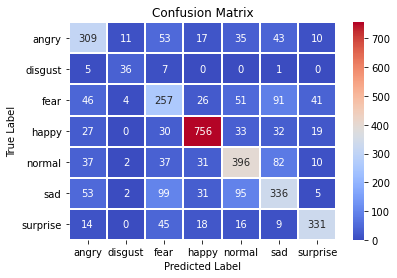

              precision    recall  f1-score   support

           0       0.63      0.65      0.64       478
           1       0.65      0.73      0.69        49
           2       0.49      0.50      0.49       516
           3       0.86      0.84      0.85       897
           4       0.63      0.67      0.65       595
           5       0.57      0.54      0.55       621
           6       0.80      0.76      0.78       433

    accuracy                           0.67      3589
   macro avg       0.66      0.67      0.67      3589
weighted avg       0.68      0.67      0.68      3589



In [21]:
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), test_generator.samples))
labels = ["angry", "disgust", "fear", "happy", "normal", "sad", "surprise"]
show_confusion_matrix(predicted_classes, ground_truth, labels)
print(classification_report(predicted_classes, ground_truth))

# Seconda fase SPARSE

Importiamo le librerie necessarie

In [6]:
from keras.layers import Input
from keras.models import Sequential

Carichiamo il modello addestrato.

In [7]:
model = load_model('../saves/redense_model.hdf5')

Andiamo a definire la clsse **Sparse** con i metodi **_init_**, **_call_** e **get_config**.

In [8]:
class Sparse(Constraint):
    def __init__(self, mask):
        self.mask = K.cast_to_floatx(mask)
    
    def __call__(self,x):
        return self.mask * x
    
    def get_config(self):
        return {'mask': self.mask}

Nella funzione creata di seguito andiamo a calcolare, per ogni layer del modello, una percentuale del peso e se quest'ultima dovesse essere vicina a 0, viene settato a 0 il valore di quel peso. Così facendo restituiamo una maschera con la percentuale dei pesi il più possibile vicina a 0, in modo tale, da incrementare l'accuratezza del modello durante la fase di training. Questo è stato possibile grazie ad una sparsity_mask, nella quale è stato impostato uno sparsity_rate del 60%. 

In [9]:
def create_sparsity_masks(model,sparsity):
    weights_list = model.get_weights()
    masks = []
    for weights in weights_list:
        #We can ignore biases
        if len(weights.shape) > 1:
            weights_abs = np.abs(weights)
            masks.append((weights_abs>np.percentile(weights_abs,sparsity))*1.)
    return masks

Richiamiamo la funzione **create_sparsity_masks** per ottenera una maschera con pesi vicini a 0.

In [10]:
masks = create_sparsity_masks(model,60)

Consideriamo tutti i layer della VGGFace andando a impostare un **kernel_constraint** solo per i layer convoluzionali.

In [11]:
input_ = Input(shape=(224, 224, 3))

x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1', kernel_constraint=Sparse(masks[0]))(input_)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2', kernel_constraint=Sparse(masks[1]))(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1', kernel_constraint=Sparse(masks[2]))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2', kernel_constraint=Sparse(masks[3]))(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1', kernel_constraint=Sparse(masks[4]))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2', kernel_constraint=Sparse(masks[5]))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3', kernel_constraint=Sparse(masks[6]))(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1', kernel_constraint=Sparse(masks[7]))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2', kernel_constraint=Sparse(masks[8]))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3', kernel_constraint=Sparse(masks[9]))(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1', kernel_constraint=Sparse(masks[10]))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2', kernel_constraint=Sparse(masks[11]))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3', kernel_constraint=Sparse(masks[12]))(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool5')(x)

x = Flatten(name='flatten')(x)
x = Dense(4096, name='fc6', kernel_constraint=Sparse(masks[13]))(x)
x = Activation('relu', name='fc6/relu')(x)
x = Dropout(0.7, name = 'Dropout')(x)
x = Dense(4096, name='fc7', kernel_constraint=Sparse(masks[14]))(x)
x = Activation('relu', name='fc7/relu')(x)
x = Dense(7, activation = 'softmax', kernel_constraint=Sparse(masks[15]))(x)

sparse_model = Model(input_, x)
layers = [l for l in sparse_model.layers]
for i in range(0, 18):
     layers[i].trainable = False
        
sparse_model.summary()
#Get weights from densely trained model
sparse_model.set_weights(model.get_weights())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

Successivamente carichiamo la cartella contente le immagini di Train e Validation. Attraverso il metodo **ImageDataGenerator** vengono applicate delle funzioni di pre-processing e un flip orizzontale a tali immagini.

In [12]:
train_folder = "../Train"
val_folder = "../Val"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True)

Attraverso il metodo **flow_from_directory** creiamo i batch con le immagini preprocessate. Inizialmente abbiamo settato un batchsize di train pari a 512, successivamente modificato a 32 a causa di un errore dovuto ad un memory leak.

In [13]:
train_batchsize = 32
val_batchsize = 8
IMAGE_SIZE = 224
train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=train_batchsize,
        class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
        val_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=val_batchsize,
        class_mode="categorical",
        shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


Per evitare di avere una **val_acc** il cui valore rimane invariato per un numero elevato di epoche, utilizziamo il metodo **ReduceLROnPlateau** per decrementare il learning rate di 10 unità ogni 10 epoche. Ci avvaliamo della funzione **CSVLogger** per salvare un file .log contente tutte le informazioni dell'addestramento.

In [14]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1 , patience = 10)

csv_logger = CSVLogger('sparse2_training.log', separator=',', append=False)
callbacks_list = [reduce_lr, csv_logger]

Andiamo a leggere i valori dei learning rate dal file **.log** utilizzando il metodo **read_csv** e li inseriamo nella variabile **lr**.

In [15]:
log = pd.read_csv("../notebook/redense_training.log")
dim = len(log['lr'])
lr = log['lr']

Settiamo un numero di epoche pari a 50 e un learning rate uguale all'ultimo valore letto dal file .log, come ottimizzatore utilizziamo l'**SGD** con un momentum settato a 0.9. E' importante settare questi iperparametri in quanto andranno ad influenzare il training del modello.

In [16]:
num_epochs = 50
learning_rate = lr[dim-1]
sgd = SGD(lr=learning_rate, momentum = 0.9)
sparse_model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['acc'])

Effettuiamo il training del modello attraverso il metodo **fit_generator** e successivamente salviamo il modello nella cartella saves.

In [17]:
history = sparse_model.fit_generator(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    verbose=1,
    callbacks=callbacks_list
)
model.save('../saves/sparse2_model.hdf5')

Epoch 1/50
898/898 [==============================] - 293s 326ms/step - loss: 0.5307 - acc: 0.8114 - val_loss: 0.9261 - val_acc: 0.6617
Epoch 2/50
898/898 [==============================] - 266s 296ms/step - loss: 0.5313 - acc: 0.8139 - val_loss: 0.9072 - val_acc: 0.6509
Epoch 3/50
898/898 [==============================] - 266s 296ms/step - loss: 0.5285 - acc: 0.8127 - val_loss: 1.1651 - val_acc: 0.6492
Epoch 4/50
898/898 [==============================] - 265s 295ms/step - loss: 0.5268 - acc: 0.8147 - val_loss: 1.1495 - val_acc: 0.6500
Epoch 5/50
898/898 [==============================] - 266s 296ms/step - loss: 0.5239 - acc: 0.8152 - val_loss: 0.9105 - val_acc: 0.6509
Epoch 6/50
898/898 [==============================] - 266s 296ms/step - loss: 0.5280 - acc: 0.8135 - val_loss: 0.9186 - val_acc: 0.6495
Epoch 7/50
898/898 [==============================] - 266s 296ms/step - loss: 0.5297 - acc: 0.8134 - val_loss: 0.9188 - val_acc: 0.6495
Epoch 8/50
898/898 [============================

# Plot fase SPARSE

Effettuiamo il **plot** delle metriche del modello.

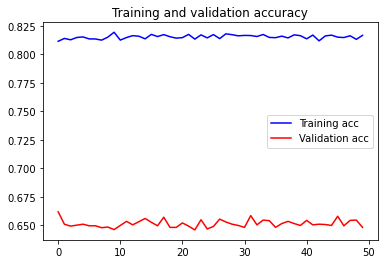

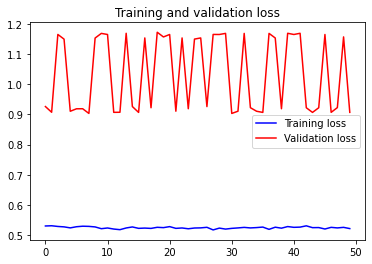

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Test fase SPARSE

importiamo le librerie del modello

In [19]:
import random
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns

Nella funzione creata di seguito si procede con la costruzione della matrice di confusione.

In [3]:
def show_confusion_matrix(validations, predictions, labels):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Carichiamo il modello addestrato.


In [4]:
model = load_model('../saves/sparse2_model.hdf5')

Una volta aver creato la matrice di confusione, procediamo con il caricamento delle immagini di test. Esse avranno dimensione 224X224, inoltre la dimensione di batchsize è stata impostata a 1.

In [5]:
test_folder = "../Test"
IMAGE_SIZE = 224
random.seed(3)
test_batchsize = 1

Successivamente carichiamo la cartella contente le immagini di Train e Validation. Attraverso il metodo **ImageDataGenerator** vengono applicate delle funzioni di pre-processing e un flip orizzontale a tali immagini. Attraverso il metodo **flow_from_directory** creiamo i batch con le immagini preprocessate.

In [6]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 3589 images belonging to 7 classes.


Andiamo a leggere le classi assegnate agli esempi di test e il corrispettivo indice numerico.

In [7]:
ground_truth = test_generator.classes
label2index = test_generator.class_indices
idx2label = dict((v, k) for k, v in label2index.items())

Attraverso il mettodo **predict_generator** effettuiamo la classificazione delle immagini.

In [8]:
predictions = model.predict_generator(test_generator,
                      steps=test_generator.samples / test_generator.batch_size,
                      verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

3589/3589 [==============================] - 66s 18ms/step


Una volta completata la classificazione calcoliamo gli errori effettuati dal modello, la matrice di confusione e le metriche prestazionali.

No of errors = 1168/3589


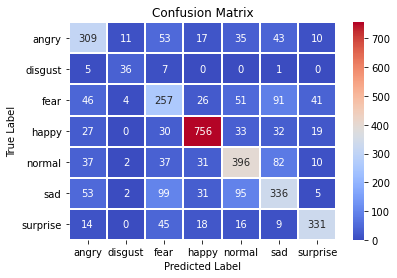

              precision    recall  f1-score   support

           0       0.63      0.65      0.64       478
           1       0.65      0.73      0.69        49
           2       0.49      0.50      0.49       516
           3       0.86      0.84      0.85       897
           4       0.63      0.67      0.65       595
           5       0.57      0.54      0.55       621
           6       0.80      0.76      0.78       433

    accuracy                           0.67      3589
   macro avg       0.66      0.67      0.67      3589
weighted avg       0.68      0.67      0.68      3589



In [9]:
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), test_generator.samples))
labels = ["angry", "disgust", "fear", "happy", "normal", "sad", "surprise"]
show_confusion_matrix(predicted_classes, ground_truth, labels)
print(classification_report(predicted_classes, ground_truth))

# Terza fase DENSE

Importiamo le librerie necessarie

In [2]:
from keras.layers import Input
from keras.models import Sequential

Carichiamo il modello addestrato.

In [3]:
model = load_model('../saves/sparse2_model.hdf5')

Consideriamo tutti i layer della VGGFace eliminando i **kernel_constraint** aggiunti ai layer convoluzionali.

In [4]:
input_ = Input(shape=(224, 224, 3))

x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(input_)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool5')(x)

x = Flatten(name='flatten')(x)
x = Dense(4096, name='fc6')(x)
x = Activation('relu', name='fc6/relu')(x)
x = Dropout(0.7, name = 'Dropout')(x)
x = Dense(4096, name='fc7')(x)
x = Activation('relu', name='fc7/relu')(x)
x = Dense(7, activation = 'softmax')(x)

redense_model = Model(input_, x)
layers = [l for l in redense_model.layers]
for i in range(0, 18):
     layers[i].trainable = False
        
redense_model.summary()
#Get weights from densely trained model
redense_model.set_weights(model.get_weights())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

Successivamente carichiamo la cartella contente le immagini di Train e Validation. Attraverso il metodo **ImageDataGenerator** vengono applicate delle funzioni di pre-processing e un flip orizzontale a tali immagini.

In [5]:
train_folder = "../FaceDetection/Train"
val_folder = "../FaceDetection/Val"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True)

Attraverso il metodo **flow_from_directory** creiamo i batch con le immagini preprocessate. Inizialmente abbiamo settato un batchsize di train pari a 512, successivamente modificato a 32 a causa di un errore dovuto ad un memory leak.

In [6]:
train_batchsize = 32
val_batchsize = 8
IMAGE_SIZE = 224
train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=train_batchsize,
        class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
        val_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=val_batchsize,
        class_mode="categorical",
        shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


Per evitare di avere una **val_acc** il cui valore rimane invariato per un numero elevato di epoche, utilizziamo il metodo **ReduceLROnPlateau** per decrementare il learning rate di 10 unità ogni 10 epoche. Ci avvaliamo della funzione **CSVLogger** per salvare un file .log contente tutte le informazioni dell'addestramento.

In [7]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1 , patience = 10)

csv_logger = CSVLogger('dense3_training.log', separator=',', append=False)
callbacks_list = [reduce_lr, csv_logger]

Andiamo a leggere i valori dei learning rate dal file **.log** utilizzando il metodo **read_csv** e li inseriamo nella variabile **lr**.

In [8]:
log = pd.read_csv('../notebook/sparse2_training.log')
dim = len(log['lr'])
lr = log['lr']

Settiamo un numero di epoche pari a 50 e un learning rate uguale all'ultimo valore letto dal file .log, come ottimizzatore utilizziamo l'**SGD** con un momentum settato a 0.9. E' importante settare questi iperparametri in quanto andranno ad influenzare il training del modello.

In [9]:
num_epochs = 50
learning_rate = lr[dim-1]
sgd = SGD(lr=learning_rate, momentum = 0.9)
redense_model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['acc'])

Effettuiamo il training del modello attraverso il metodo **fit_generator** e successivamente salviamo il modello nella cartella saves.

In [10]:
history = redense_model.fit_generator(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    verbose=1,
    callbacks=callbacks_list
)
model.save('../saves/dense3_model.hdf5')

Epoch 1/50
898/898 [==============================] - 260s 289ms/step - loss: 0.3951 - acc: 0.8642 - val_loss: 1.4361 - val_acc: 0.6629
Epoch 2/50
898/898 [==============================] - 257s 286ms/step - loss: 0.3930 - acc: 0.8648 - val_loss: 1.0698 - val_acc: 0.6707
Epoch 3/50
898/898 [==============================] - 257s 286ms/step - loss: 0.3952 - acc: 0.8635 - val_loss: 1.0587 - val_acc: 0.6665
Epoch 4/50
898/898 [==============================] - 257s 287ms/step - loss: 0.3916 - acc: 0.8650 - val_loss: 1.4354 - val_acc: 0.6651
Epoch 5/50
898/898 [==============================] - 257s 287ms/step - loss: 0.3910 - acc: 0.8643 - val_loss: 1.0581 - val_acc: 0.6684
Epoch 6/50
898/898 [==============================] - 257s 287ms/step - loss: 0.3945 - acc: 0.8610 - val_loss: 1.0507 - val_acc: 0.6643
Epoch 7/50
898/898 [==============================] - 257s 287ms/step - loss: 0.3964 - acc: 0.8621 - val_loss: 1.4317 - val_acc: 0.6679
Epoch 8/50
898/898 [============================

# Plot fase DENSE

Effettuiamo il **plot** delle metriche del modello.

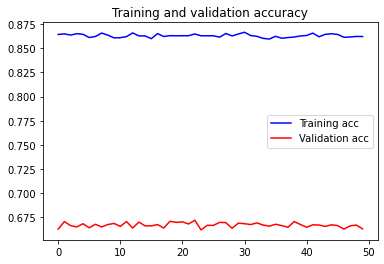

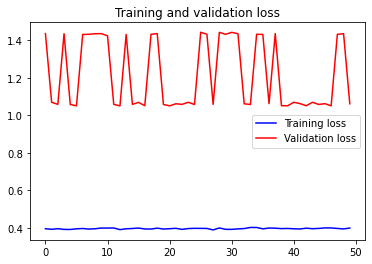

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Test fase DENSE

Importiamo le librerie necessarie.

In [21]:
import random
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns

Carichiamo il modello addestrato.

In [13]:
model = load_model('../saves/dense3_model.hdf5')

Nella funzione creata di seguito si procede con la costruzione della matrice di confusione.

In [14]:
def show_confusion_matrix(validations, predictions, labels):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Una volta aver creato la matrice di confusione, procediamo con il caricamento delle immagini di test. Esse avranno dimensione 224X224, inoltre la dimensione di batchsize è stata impostata a 1.

In [15]:
test_folder = "../Test"
IMAGE_SIZE = 224
random.seed(3)
test_batchsize = 1

Successivamente carichiamo la cartella contente le immagini di Train e Validation. Attraverso il metodo **ImageDataGenerator** vengono applicate delle funzioni di pre-processing e un flip orizzontale a tali immagini. Attraverso il metodo **flow_from_directory** creiamo i batch con le immagini preprocessate.

In [16]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 3589 images belonging to 7 classes.


Andiamo a leggere le classi assegnate agli esempi di test e il corrispettivo indice numerico.

In [24]:
ground_truth = test_generator.classes
label2index = test_generator.class_indices
idx2label = dict((v, k) for k, v in label2index.items())

Attraverso il mettodo **predict_generator** effettuiamo la classificazione delle immagini.

In [23]:
predictions = model.predict_generator(test_generator,
                      steps=test_generator.samples / test_generator.batch_size,
                      verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

3589/3589 [==============================] - 62s 17ms/step


Una volta completata la classificazione calcoliamo gli errori effettuati dal modello, la matrice di confusione e le metriche prestazionali.

No of errors = 1168/3589


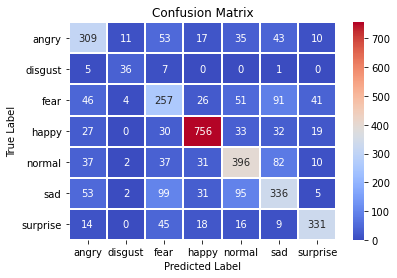

              precision    recall  f1-score   support

           0       0.63      0.65      0.64       478
           1       0.65      0.73      0.69        49
           2       0.49      0.50      0.49       516
           3       0.86      0.84      0.85       897
           4       0.63      0.67      0.65       595
           5       0.57      0.54      0.55       621
           6       0.80      0.76      0.78       433

    accuracy                           0.67      3589
   macro avg       0.66      0.67      0.67      3589
weighted avg       0.68      0.67      0.68      3589



In [25]:
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), test_generator.samples))
labels = ["angry", "disgust", "fear", "happy", "normal", "sad", "surprise"]
show_confusion_matrix(predicted_classes, ground_truth, labels)
print(classification_report(predicted_classes, ground_truth))